In [83]:
import pandas as pd

In [24]:
#pip install git+https://github.com/quantopian/pyfolio
# import again if first time not work
import pyfolio

In [25]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

In [26]:
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    #df=df.dropna()
    print('Sharpe: ',(252**0.5)*df['daily_return'].mean()/ df['daily_return'].std())
    return df

In [27]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

In [28]:
def get_account_value(model_name):
    df_account_value=pd.DataFrame()
    for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
        temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format(model_name,i))
        df_account_value = df_account_value.append(temp,ignore_index=True)
    df_account_value = pd.DataFrame({'account_value':df_account_value['0']})
    sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
    print(sharpe)
    df_account_value=df_account_value.join(df_trade_date[63:].reset_index(drop=True))
    return df_account_value

## DJIA

In [130]:
dji = pd.read_csv("data/^DJI.csv")
test_dji=dji[(dji['Date']>='2016-01-01') & (dji['Date']<='2020-06-30')]
test_dji = test_dji.reset_index(drop=True)

In [131]:
test_dji.shape

(1131, 7)

In [132]:
test_dji.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,17405.480469,17405.480469,16957.630859,17148.939453,17148.939453,148060000
1,2016-01-05,17147.500000,17195.839844,17038.609375,17158.660156,17158.660156,105750000
2,2016-01-06,17154.830078,17154.830078,16817.619141,16906.509766,16906.509766,120250000
3,2016-01-07,16888.359375,16888.359375,16463.630859,16514.099609,16514.099609,176240000
4,2016-01-08,16519.169922,16651.890625,16314.570313,16346.450195,16346.450195,141850000


In [133]:
test_dji['daily_return']=test_dji['Adj Close'].pct_change(1)

In [134]:
dow_strat = backtest_strat(test_dji)

## Ensemble Strategy

In [168]:
df=pd.read_csv('data/dow_30_2009_2020.csv')

In [169]:
rebalance_window = 63
validation_window = 63
unique_trade_date = df[(df.datadate > 20151001)&(df.datadate <= 20200707)].datadate.unique()


In [170]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

In [171]:
ensemble_account_value = get_account_value('ensemble')

1.2473152968774597


<AxesSubplot:>

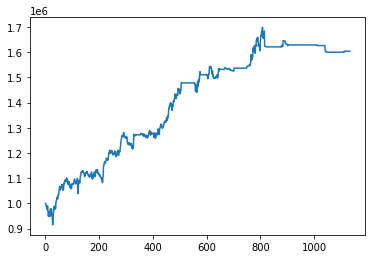

In [172]:
ensemble_account_value.account_value.plot()

In [173]:
ensemble_account_value = get_daily_return(ensemble_account_value)

Sharpe:  1.2473152968774597


In [174]:
ensemble_account_value['Date'] = test_dji['Date']

In [175]:
ensemble_account_value.head()

,account_value,datadate,daily_return,Date
0,1000000.000,20160104,NaN,2016-01-04
1,999611.248,20160105,-0.000389,2016-01-05
2,995952.780,20160106,-0.003660,2016-01-06
3,988518.089,20160107,-0.007465,2016-01-07
4,984545.842,20160108,-0.004018,2016-01-08


In [176]:
ensemble_strat = backtest_strat(ensemble_account_value[0:1097])

In [177]:
#ensemble_account_value.to_csv('results/df_account_value_ensemble_daily_return.csv',index=False)

Start date,2016-01-04
End date,2020-05-12
Total months,52
,Backtest
Annual return,11.402%
Cumulative returns,60.006%
Annual volatility,8.879%
Sharpe ratio,1.26
Calmar ratio,1.34
Stability,0.91
Max drawdown,-8.528%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.53,2016-01-04,2016-02-11,2016-03-01,42
1,5.84,2019-03-21,2020-04-08,NaT,NaN
2,5.70,2016-04-27,2016-06-27,2016-07-11,54
3,5.15,2017-03-01,2017-04-19,2017-07-14,98
4,4.55,2016-10-05,2016-11-03,2016-11-09,26


/opt/anaconda3/envs/pj2/lib/python3.6/site-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


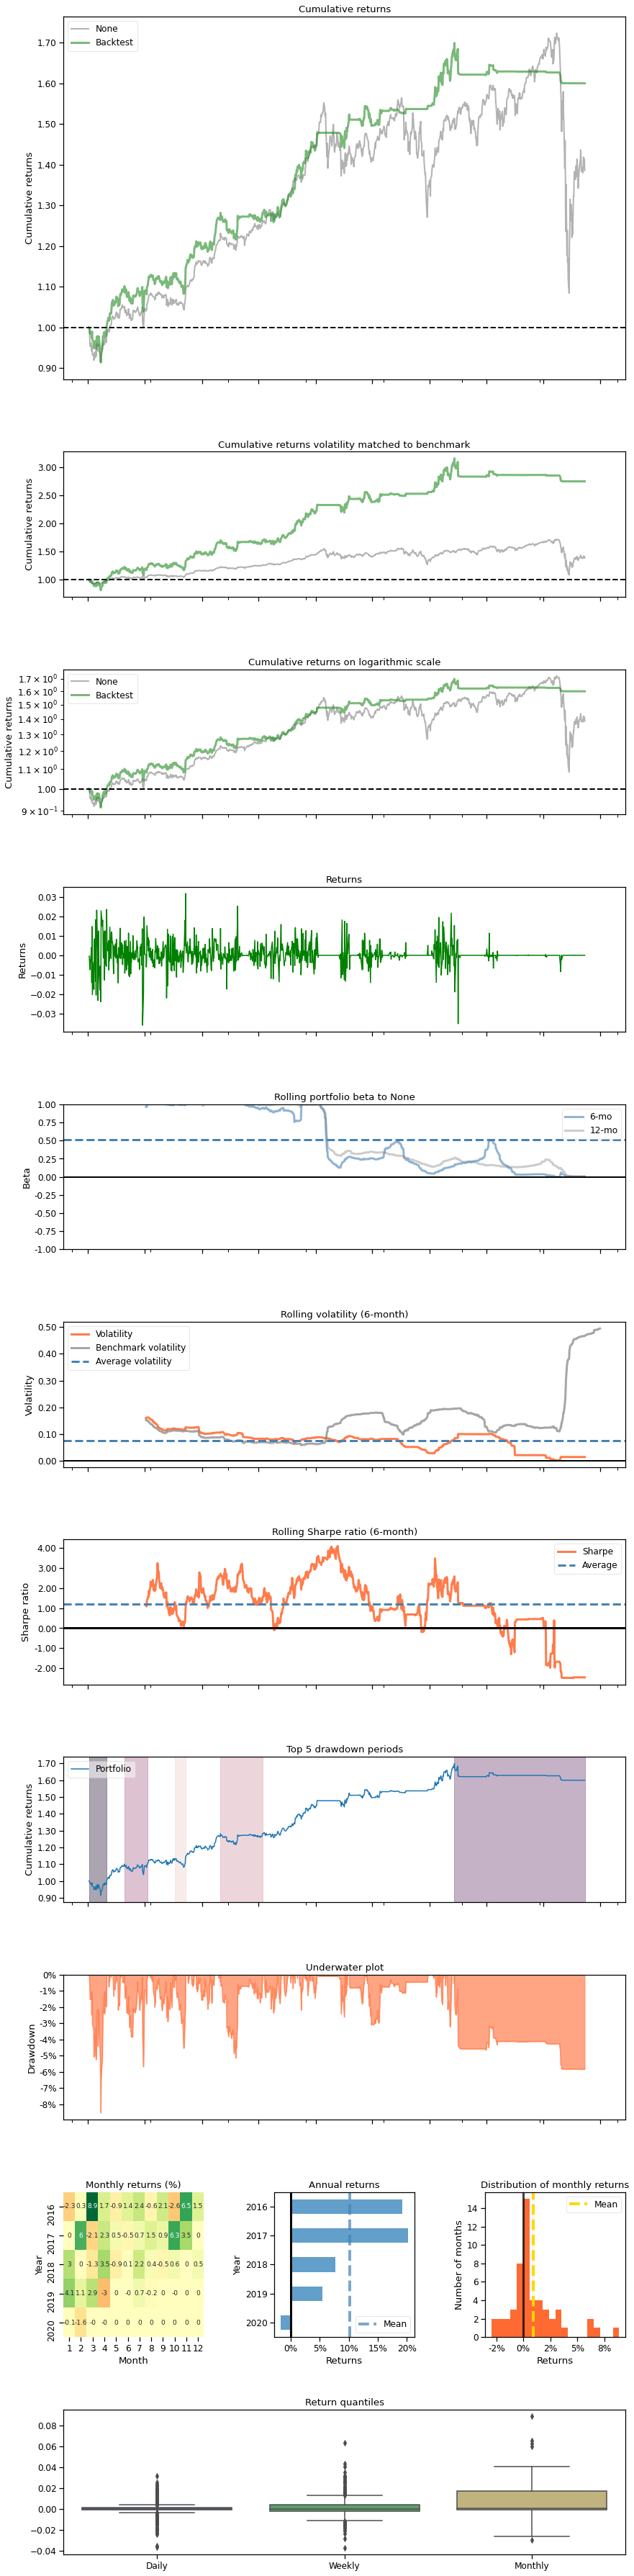

In [178]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = ensemble_strat,
                                   benchmark_rets=dow_strat, set_context=False)